In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\val",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\SujanD datasets\Cancer cells\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 6660 images belonging to 4 classes.
Found 1918 images belonging to 4 classes.
Found 1293 images belonging to 4 classes.
Train classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Validation classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Test classes: {'A': 0, 'B': 1, 'C': 2, 'D': 3}


In [ ]:


def inception_block(x, f1, f3r, f3, f5r, f5, pool_proj):
    path1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    
    path2 = Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(f3, (3,3), padding='same', activation='relu')(path2)
    
    path3 = Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(f5, (5,5), padding='same', activation='relu')(path3)
    
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(pool_proj, (1,1), padding='same', activation='relu')(path4)
    
    return tf.keras.layers.concatenate([path1, path2, path3, path4], axis=-1)



def GoogLeNet(input_shape=(1024,1024,3), num_classes=4):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    
    x = inception_block(x, 64, 96, 128, 16, 32, 32)    
    x = inception_block(x, 128, 128, 192, 32, 96, 64)   
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    
    x = inception_block(x, 192, 96, 208, 16, 48, 64)   
    x = inception_block(x, 160, 112, 224, 24, 64, 64)  
    x = inception_block(x, 128, 128, 256, 24, 64, 64)   
    x = inception_block(x, 112, 144, 288, 32, 64, 64)   
    x = inception_block(x, 256, 160, 320, 32, 128, 128) 
    x =MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    
    x = inception_block(x, 256, 160, 320, 32, 128, 128) 
    x = inception_block(x, 384, 192, 384, 48, 128, 128) 
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model =Model(inputs=input_layer, outputs=output)
    return model

model = GoogLeNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=5,
    verbose=1,
    cooldown=1,
    min_delta=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

check_path = '/content/drive/MyDrive/google net.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

hist_scratch =model.fit(
    train_generator,
    validation_data=val_generator,  
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/30
417/417 [==============================] - 75s 156ms/step - loss: 0.8901 - accuracy: 0.5932 - val_loss: 0.9609 - val_accuracy: 0.5501

Epoch 00001: val_loss improved from inf to 0.96091, saving model to /content/drive/MyDrive\google net.weights.h5
Epoch 2/30
417/417 [==============================] - 62s 149ms/step - loss: 0.7069 - accuracy: 0.6923 - val_loss: 0.8525 - val_accuracy: 0.6137

Epoch 00002: val_loss improved from 0.96091 to 0.85255, saving model to /content/drive/MyDrive\google net.weights.h5
Epoch 3/30
417/417 [==============================] - 61s 146ms/step - loss: 0.6490 - accuracy: 0.7164 - val_loss: 0.9417 - val_accuracy: 0.5563

Epoch 00003: val_loss did not improve from 0.85255
Epoch 4/30
417/417 [==============================] - 60s 145ms/step - loss: 0.6056 - accuracy: 0.7366 - val_loss: 0.8309 - val_accuracy: 0.5506

Epoch 00004: val_loss improved from 0.85255 to 0.83093, saving model to /content/drive/MyDrive\google net.weights.h5
Epoch 5/30
417/417

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

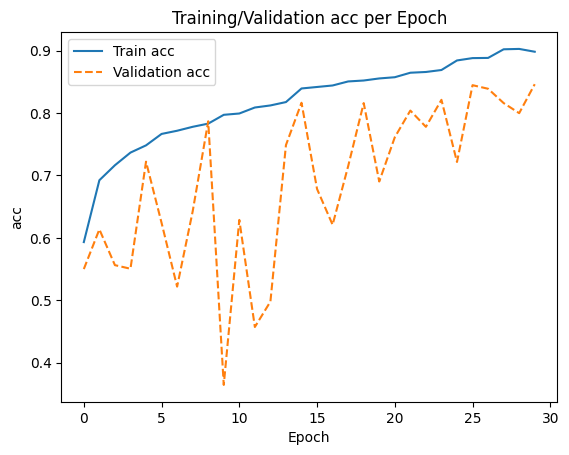

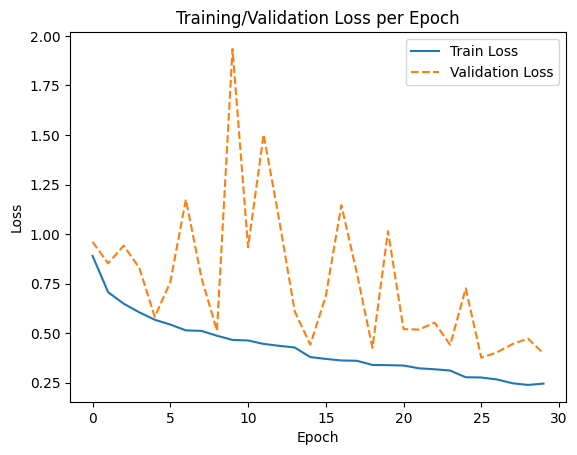

In [ ]:
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [7]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'A': 0, 'B': 1, 'C': 2, 'D': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[3 3 3 ... 3 3 3]


In [8]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.7463263727764888
F1 0.73673949581769
precision 0.7711933143773695
recall 0.7714876018202724
jaccard 0.5899442001328298
classification_report
               precision    recall  f1-score   support

           0       1.00      0.61      0.75       466
           1       0.83      0.71      0.77       233
           2       0.81      0.85      0.83       411
           3       0.44      0.92      0.60       183

    accuracy                           0.75      1293
   macro avg       0.77      0.77      0.74      1293
weighted avg       0.83      0.75      0.76      1293




[[282   4   2 178]
 [  0 165  67   1]
 [  0  29 349  33]
 [  0   0  14 169]]
